# 22 · Segmentación por color (HSV) con OpenCV

## 1) Teoría

- **H (Hue)** 0–179 (OpenCV), **S** 0–255, **V** 0–255.
- Segmentación: `mask = inRange(HSV, [Hmin,Smin,Vmin], [Hmax,Smax,Vmax])`.
- Refinar con apertura/cierre (morfología) para ruido/huecos.

## 2) Cargar imagen y convertir a HSV

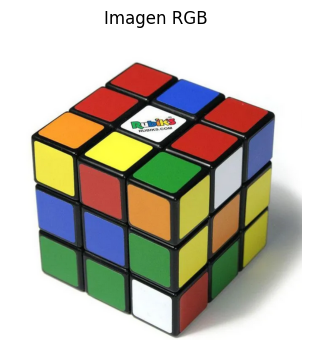

In [7]:
import cv2, numpy as np, matplotlib.pyplot as plt
IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\rubik.png"
bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(4,4)); plt.imshow(rgb); plt.title('Imagen RGB'); plt.axis('off'); plt.show()


## 3) Funciones auxiliares

In [8]:
def apply_hsv_threshold(hsv_img, hmin, smin, vmin, hmax, smax, vmax):
    import numpy as np, cv2
    lower = np.array([hmin, smin, vmin], dtype=np.uint8)
    upper = np.array([hmax, smax, vmax], dtype=np.uint8)
    return cv2.inRange(hsv_img, lower, upper)

def morph_ops(mask, op='none', ksize=3, iters=1):
    import numpy as np, cv2
    if op == 'none' or ksize <= 1 or iters <= 0:
        return mask
    kernel = np.ones((ksize, ksize), np.uint8)
    if op == 'open':
        return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iters)
    if op == 'close':
        return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iters)
    if op == 'erode':
        return cv2.erode(mask, kernel, iterations=iters)
    if op == 'dilate':
        return cv2.dilate(mask, kernel, iterations=iters)
    return mask

def overlay_mask(rgb_img, mask, alpha=0.45, color=(0,255,0)):
    import numpy as np
    overlay = rgb_img.copy()
    color_layer = np.zeros_like(rgb_img, np.uint8); color_layer[:] = np.array(color, np.uint8)
    idx = mask > 0
    overlay[idx] = (alpha*color_layer[idx] + (1-alpha)*overlay[idx]).astype(np.uint8)
    return overlay


## 4) Interactivo: rango HSV y morfología

In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
hmin = widgets.IntSlider(value=0, min=0, max=179, step=1, description='H min')
hmax = widgets.IntSlider(value=179, min=0, max=179, step=1, description='H max')
smin = widgets.IntSlider(value=50, min=0, max=255, step=1, description='S min')
smax = widgets.IntSlider(value=255, min=0, max=255, step=1, description='S max')
vmin = widgets.IntSlider(value=50, min=0, max=255, step=1, description='V min')
vmax = widgets.IntSlider(value=255, min=0, max=255, step=1, description='V max')
op = widgets.Dropdown(options=[('sin morfología','none'), ('apertura (open)','open'), ('cierre (close)','close'), ('erosión','erode'), ('dilatación','dilate')], value='none', description='Morfología')
ks  = widgets.IntSlider(value=3, min=1, max=15, step=2, description='kernel')
it  = widgets.IntSlider(value=1, min=1, max=5, step=1, description='iters')
alpha = widgets.FloatSlider(value=0.45, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='alpha')
display(widgets.VBox([widgets.HBox([hmin, hmax]), widgets.HBox([smin, smax]), widgets.HBox([vmin, vmax]), widgets.HBox([op, ks, it, alpha])]))
out = widgets.Output(); display(out)
def refresh(*args):
    with out:
        clear_output(wait=True)
        if hmin.value > hmax.value: hmax.value = hmin.value
        if smin.value > smax.value: smax.value = smin.value
        if vmin.value > vmax.value: vmax.value = vmin.value
        mask = apply_hsv_threshold(hsv, hmin.value, smin.value, vmin.value, hmax.value, smax.value, vmax.value)
        mask_m = morph_ops(mask, op.value, ks.value, it.value)
        over = overlay_mask(rgb, mask_m, alpha=alpha.value, color=(0,255,0))
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(rgb); plt.title('RGB'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(mask_m, cmap='gray'); plt.title('Máscara HSV (morfología)'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(over); plt.title('Overlay'); plt.axis('off')
        plt.tight_layout(); plt.show()
for w in [hmin,hmax,smin,smax,vmin,vmax,op,ks,it,alpha]: w.observe(refresh, names='value')
refresh()


Output()

## 5) Consejos rápidos

- Para colores con envoltura en H (p. ej., rojo alrededor de 0/179), usa dos rangos y combina máscaras (`mask = mask1 | mask2`).
- Apertura quita ruido; cierre rellena huecos.
- Si la iluminación cambia mucho, ajusta V y considera normalizar brillo (ecualizar V).